In [1]:
import numpy as np
import matplotlib.pyplot as plt


2025-04-21 22:32:37.769731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 22:32:37.783111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745263957.796943  201623 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745263957.800899  201623 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 22:32:37.817245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 21651 files belonging to 120 classes.


I0000 00:00:1745263966.893101  201623 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-04-21 22:32:59.536147: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-21 22:32:59.670418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Split: 15155, 4330, 2166


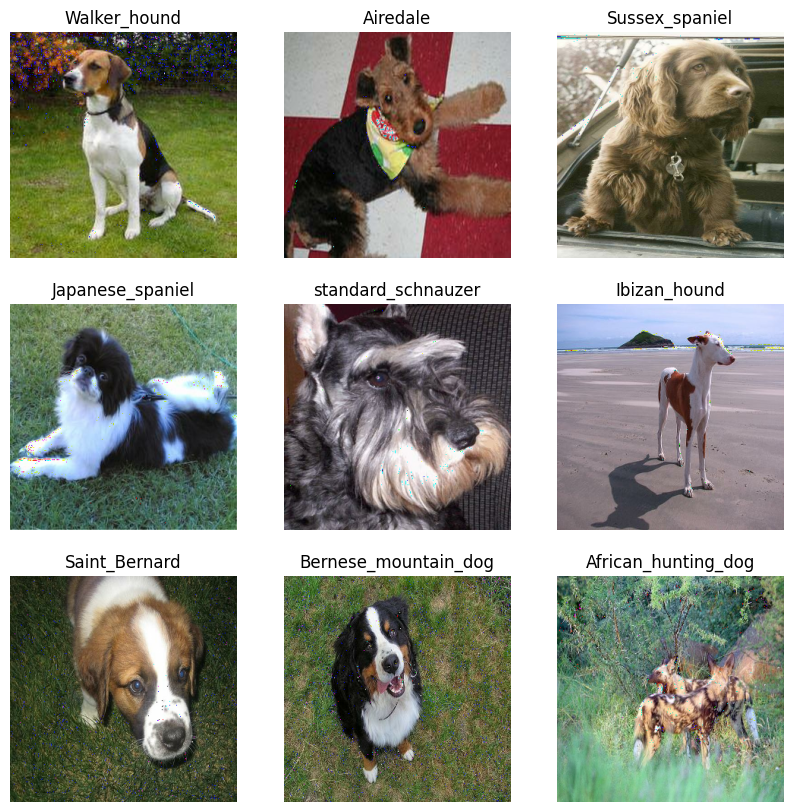

In [ ]:
from keras import utils

dataset_path = "./dataset"


ds = utils.image_dataset_from_directory("./dataset", image_size=(299, 299), interpolation="lanczos5", seed=12151251, batch_size=None)
class_names = ds.class_names

ds_count = sum(1 for _ in ds)
  
train_size = 0.7
valid_size = 0.2

train_count = int(ds_count * train_size)
valid_count = int(ds_count * valid_size)
test_count = int(ds_count - train_count - valid_count) 


print(f"Split: {train_count}, {valid_count}, {test_count}")

train_ds = ds.take(train_count).batch(32)
valid_ds = ds.skip(train_count).take(valid_count).batch(32)
test_ds = ds.skip(train_count + valid_count).batch(32)

for i in range(len(class_names)):
  class_names[i] = class_names[i].split("-")[-1]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

2025-04-21 22:33:00.403976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


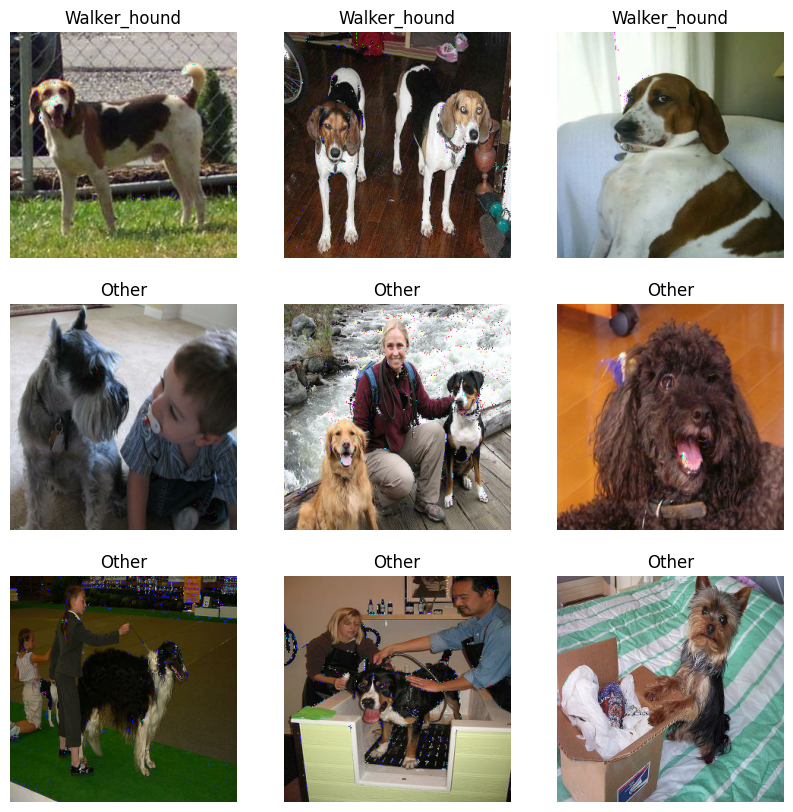

In [3]:
import tensorflow as tf

target_classname = "Walker_hound"
assert target_classname in class_names

target_index = class_names.index(target_classname)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))
valid_ds = valid_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))
test_ds = test_ds.map(lambda x, y: (x, tf.cast(tf.equal(y, target_index), tf.int32)))

class_names = ['Other', target_classname]

plt.figure(figsize=(10, 10))
i = 0
for img, label in train_ds.unbatch().filter(lambda x, y: tf.equal(y, 1)).take(3):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis("off")
  i += 1
  
for img, label in train_ds.unbatch().filter(lambda x, y: tf.equal(y, 0)).take(6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis("off")
  i += 1
    

In [4]:
from keras import models, layers, applications


def MyNet(input_shape=(299, 299, 3)):
  inputs = layers.Input(shape=input_shape)
  x = layers.Resizing(299, 299)(inputs)
  x = layers.Rescaling(1./255)(x)
  x = layers.RandomColorJitter(
    value_range=(0, 1),
    brightness_factor=0.2,
    contrast_factor=0.2,
    saturation_factor=0.2,
    hue_factor=0.2
  )(x)
  x = layers.RandomFlip(
    mode="horizontal_and_vertical"
  )(x)

  inceptionv3 = applications.InceptionV3(include_top=False, input_tensor=x)
  
  x = inceptionv3.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(4096, activation="relu")(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = models.Model(inputs=inputs, outputs=outputs)
  
  return model, inceptionv3


In [5]:
from keras import optimizers

epochs = 10

initial_learning_rate = 1e-3
final_learning_rate = 1e-6
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1 / epochs)

steps_per_epoch = train_count

learning_rate = optimizers.schedules.ExponentialDecay(
  initial_learning_rate=initial_learning_rate,
  decay_steps=steps_per_epoch,
  decay_rate=learning_rate_decay_factor
)

model, base_model = MyNet(input_shape=(299, 299, 3))

model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 299, 299,  │          0 │ resizing[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_color_jitter │ (None, 299, 299,  │          0 │ rescaling[0][0]   │
│ (RandomColorJitter) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 299, 299,  │          0 │ random_color_jit… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ random_flip[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]  

 Total params: 30,199,585 (115.20 MB)

 Trainable params: 30,165,153 (115.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [6]:
for layer in base_model.layers:
  layer.trainable = False

class_weight = {0: 1, 1: 20}

history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, class_weight=class_weight)

Epoch 1/10


I0000 00:00:1745263985.952976  201769 service.cc:148] XLA service 0x7f58640029f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745263985.953022  201769 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-21 22:33:06.159308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745263987.343069  201769 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-21 22:33:08.416873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7330_0', 116 bytes spill stores, 216 bytes spill loads

2025-04-21 22:33:08.467250: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13567', 60 

  3/474 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8177 - loss: 4.3583   

I0000 00:00:1745263995.995762  201769 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


472/474 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8552 - loss: 1.5729

2025-04-21 22:33:35.254418: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7330', 16 bytes spill stores, 16 bytes spill loads

2025-04-21 22:33:35.303526: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7330', 20 bytes spill stores, 20 bytes spill loads

2025-04-21 22:33:35.334847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13567', 32 bytes spill stores, 32 bytes spill loads

2025-04-21 22:33:35.359501: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13567', 32 bytes spill stores, 32 bytes spill loads

2025-04-21 22:33:35.382337: I external/local_xla/xla/strea

474/474 ━━━━━━━━━━━━━━━━━━━━ 60s 99ms/step - accuracy: 0.8554 - loss: 1.5674 - val_accuracy: 0.9704 - val_loss: 0.1033
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.9399 - loss: 0.2712 - val_accuracy: 0.9471 - val_loss: 0.1781
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9371 - loss: 0.2876 - val_accuracy: 0.9464 - val_loss: 0.1816
Epoch 4/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9431 - loss: 0.2494 - val_accuracy: 0.9804 - val_loss: 0.0619
Epoch 5/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9673 - loss: 0.1507 - val_accuracy: 0.9769 - val_loss: 0.0862
Epoch 6/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9629 - loss: 0.1695 - val_accuracy: 0.9836 - val_loss: 0.0475
Epoch 7/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9616 - loss: 0.1634 - val_accuracy: 0.9822 - val_loss: 0.0516
Epoch 8/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.9625 - loss: 0.1683 - val_accurac

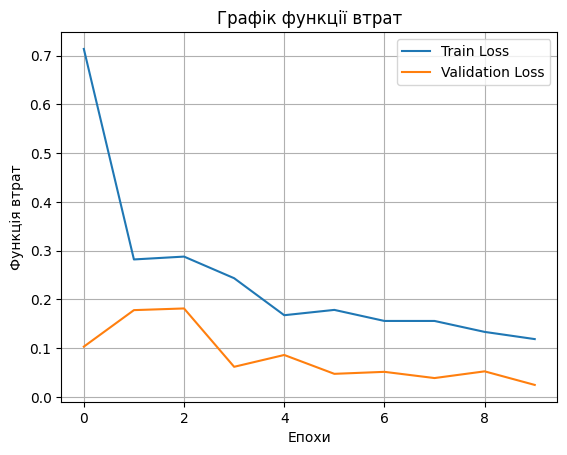

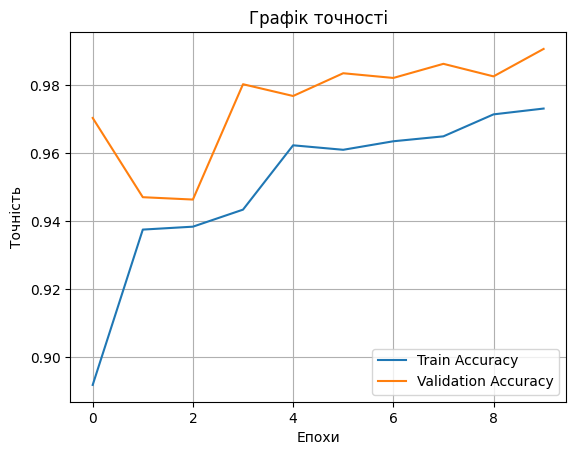

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Епохи')
plt.ylabel('Функція втрат')
plt.title('Графік функції втрат')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Графік точності')
plt.legend()
plt.grid()
plt.show()

In [8]:
model.evaluate(test_ds)

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9923 - loss: 0.0189

2025-04-21 22:39:19.862443: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2578', 16 bytes spill stores, 16 bytes spill loads

2025-04-21 22:39:19.870661: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2578_0', 16 bytes spill stores, 16 bytes spill loads

2025-04-21 22:39:20.135128: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2578', 72 bytes spill stores, 72 bytes spill loads

2025-04-21 22:39:20.274731: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2578_0', 896 bytes spill stores, 1316 bytes spill loads



68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9922 - loss: 0.0190


[0.02283058501780033, 0.9916897416114807]

In [9]:
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    predictions = model.predict(x_batch)
    pred_labels = np.array(predictions).round()
    y_true.extend(y_batch.numpy())
    y_pred.extend(pred_labels)
    
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

[array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], d

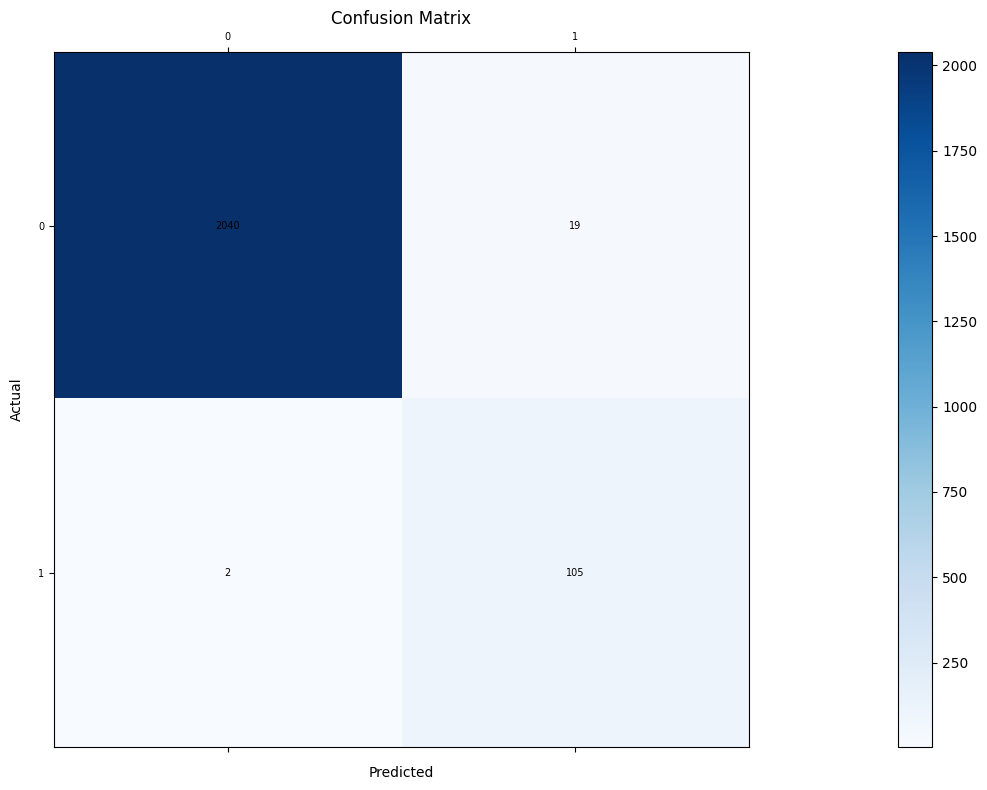

In [10]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(30, 8))
cax = ax.matshow(conf_matrix, cmap="Blues")

plt.colorbar(cax)

class_labels=range(len(class_names))

ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=7)
ax.set_yticklabels(class_labels, fontsize=7)

plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted", labelpad=10)
plt.ylabel("Actual", labelpad=10)

for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()

In [11]:
model.save("./model.keras")